# Анализ поведения игроков мобильной игры

## Описание проекта

**Цель:** Анализ поведения игроков в зависимости от источника перехода, для последующего использования полученных данных менеджерами проекта, при выборе наиболее перспективных рекламных каналов, а также планировании и реализации модели монетизации игры "Космические братья".

**Данные:** В нашем распоряжении данные по игре пользователей на первом уровне (датасет *game_actions.csv*):
- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта.

Данные о стоимости кликов по рекламным объявлениеям (датасет *ad_cost.csv*): 
- `day` - день, в который был совершен клик по объявлению;
- `source` - источник трафика;
- `cost` - стоимость кликов.

Данные об источниках привлечения игроков (датасет *user_source.csv*): 
- `user_id` - идентификатор пользователя;
- `source` - источников, с которого пришёл пользователь, установивший приложение.

**Ход выполнения проекта:**
1. Предобработка данных.
2. Исследовательский анализ данных:
- изучение количества событий по дням, распределения событий по типу, распределения построек по типу, распределения игроков по каналам привлечения;
- изучение распределения количества событий и рассчёт среднего количества событий совершаемых игроком, в т.ч. в разрезе каналов привлечения;
- рассчёт доли игроков завершивших первый уровень в целом и каждым из способов, среди всех игроков и в разрезе каналов привлечения;
- расчёт стоимости привлечения игрока по разным каналам привлечения.
3. Проверка статистической гипотезы "Время завершения уровня различается в зависимости от способа прохождения":
- посчитать для каждого пользователя, завершившего первый уровень, время затраченное на завершение;
- рассчитать среднее время завершения и оценить распределение показателя времени завершения в группе завершивших через реализацию проекта и в группе завершивших через победу над первым игроком;
- при распределении близком к нормальному использовать t-тест для непарных выборок, при ненормальном распределении использовать критерий Манна-Уитни;
- выбрать уровень статистической значимости и оценить результаты проверки статистической гипотезы.
4. Формулировка и проверка авторской гипотезы:
- доля игроков завершивших первый уровень различается в зависимости от канала привлечения:
    - выбрать уровень статистической значимости с поправкой на множественные сравнения;
    - сравнить ранее рассчитанные доли игроков завершивших первый уровень в разных каналах привлечения, используя z-тест;
- среднее количество построек на игрока различается в зависимости от факта завершения уровня и способа его завершения (сравнение трёх групп: не завершившие первый уровень, завершившие через реализацию проекта, завершившие через победу над первым игроком):
    - изучение распределения показателя и расчет среднего количества построек на игрока в каждой группе;
    - выбор статистического теста (t-тест или критерий Манна-Уитни);
    - выбор уровня статистической значимости с поправкой на множественные сравнения и оценка результатов проверки статистической гипотезы.

## Предобработка данных

In [2]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth
pd.set_option('display.float_format', '{:,.2f}'.format)

In [3]:
#загрузка данных
ad_costs = pd.read_csv('http://code.s3.yandex.net/datasets/ad_costs.csv')
game_actions = pd.read_csv('http://code.s3.yandex.net/datasets/game_actions.csv', parse_dates=['event_datetime'])
user_source = pd.read_csv('http://code.s3.yandex.net/datasets/user_source.csv')

In [4]:
def information(df): #функция для получения общих сведений о датафрейме
    print('\033[1m' + 'Общая информация:' + '\033[0m')
    df.info()
    print('\033[1m' + 'Первые 2 строки:' + '\033[0m')
    display(df.head(2))
    print('\033[1m' + 'Количество столбцов в датафрейме:' + '\033[0m', len(df.columns))
    print('\033[1m' + 'Количество строк в датафрейме:' + '\033[0m', len(df))
    print('\033[1m' + 'Количество дубликатов:' + '\033[0m', df.duplicated().sum())
    print('\033[1m' + 'Количество пропусков:' + '\033[0m')
    display(df.isna().sum())
    print('\033[1m' + 'Доля пропусков:' + '\033[0m')
    print(df.isna().sum().mean())

In [6]:
information(ad_costs)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes
Первые 2 строки:


,source,day,cost
0,facebook_ads,2020-05-03,935.88
1,facebook_ads,2020-05-04,548.35


Количество столбцов в датафрейме: 3
Количество строк в датафрейме: 28
Количество дубликатов: 0
Количество пропусков:


source    0
day       0
cost      0
dtype: int64

Доля пропусков:
0.0


В датафрейме с данными о стоимости рекламы по дням и каналам 3 столбца и 28 строк, пропущенные значения и дубликаты отсутствуют.

In [7]:
information(game_actions)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135640 non-null  datetime64[ns]
 1   event           135640 non-null  object        
 2   building_type   127957 non-null  object        
 3   user_id         135640 non-null  object        
 4   project_type    1866 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 5.2+ MB
Первые 2 строки:


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN


Количество столбцов в датафрейме: 5
Количество строк в датафрейме: 135640
Количество дубликатов: 1
Количество пропусков:


event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

Доля пропусков:
28291.4


Датафрейм, содержащий данные о действиях игроков представлен 5 столбцами и содержит 135640 строк. 

Количество пропусков в столбце `building_type` - 7683, что составляет около 6%, вероятно эти пропуски соответствуют строкам в которых отражено событие-прохождение первого уровня одним из доступных способов, и обрабатывать данные пропуски не нужно.

In [8]:
game_actions[game_actions['building_type'].isna()]['event'].value_counts()

finished_stage_1    5817
project             1866
Name: event, dtype: int64

Мы убедились, что аномальные пропуски в столбце `building_type` отсутствуют.

Доля пропусков в столбце `project_type` достигает 99%. В данном столбце ячейка заполняется только в том случае, если первый уровень пройден путём завершения проекта, в таком случае необходимость обрабатывать данные пропуски также отсутствует.

In [9]:
game_actions[~(game_actions['project_type'].isna())]['event'].value_counts()

project    1866
Name: event, dtype: int64

Предположение относительно механизма появления пропусков в столбце `project_type` подтвердилось, а значит обрабатывать их не нужно.

Также в датафрейме присутствует один дубликат, который можно просто удалить.

In [10]:
game_actions = game_actions.drop_duplicates().reset_index(drop=True) #удаление дубликата

In [11]:
information(user_source)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB
Первые 2 строки:


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct


Количество столбцов в датафрейме: 2
Количество строк в датафрейме: 13576
Количество дубликатов: 0
Количество пропусков:


user_id    0
source     0
dtype: int64

Доля пропусков:
0.0


В датафрейме отражающем каналы прихода игроков 2 столбца и 13576 строк, дубликаты и пропуски отсутствуют.

### Промежуточный вывод

1. В датафреймах с данными о рекламе и каналах привлечения клиентов отсутствуют дубликаты и пропуски.
2. Датафрейм с информацией об активностях игроков содержит 7683 пропуска (6%) в столбце `building_type` и 133774 пропуска (99%) в  столбце `project_type`, механизм формирования пропусков понятен и они не требуют обработки. Также датафрейм содержит 1 дубликат который был удалён в процессе предобработки. В столбце с датой и временем события формат object был заменен на datetime.

## Исследовательский анализ данных

### Количество событий по дням

In [12]:
game_actions['event_date'] = game_actions['event_datetime'].dt.date #выделение даты события в отдельный столбец

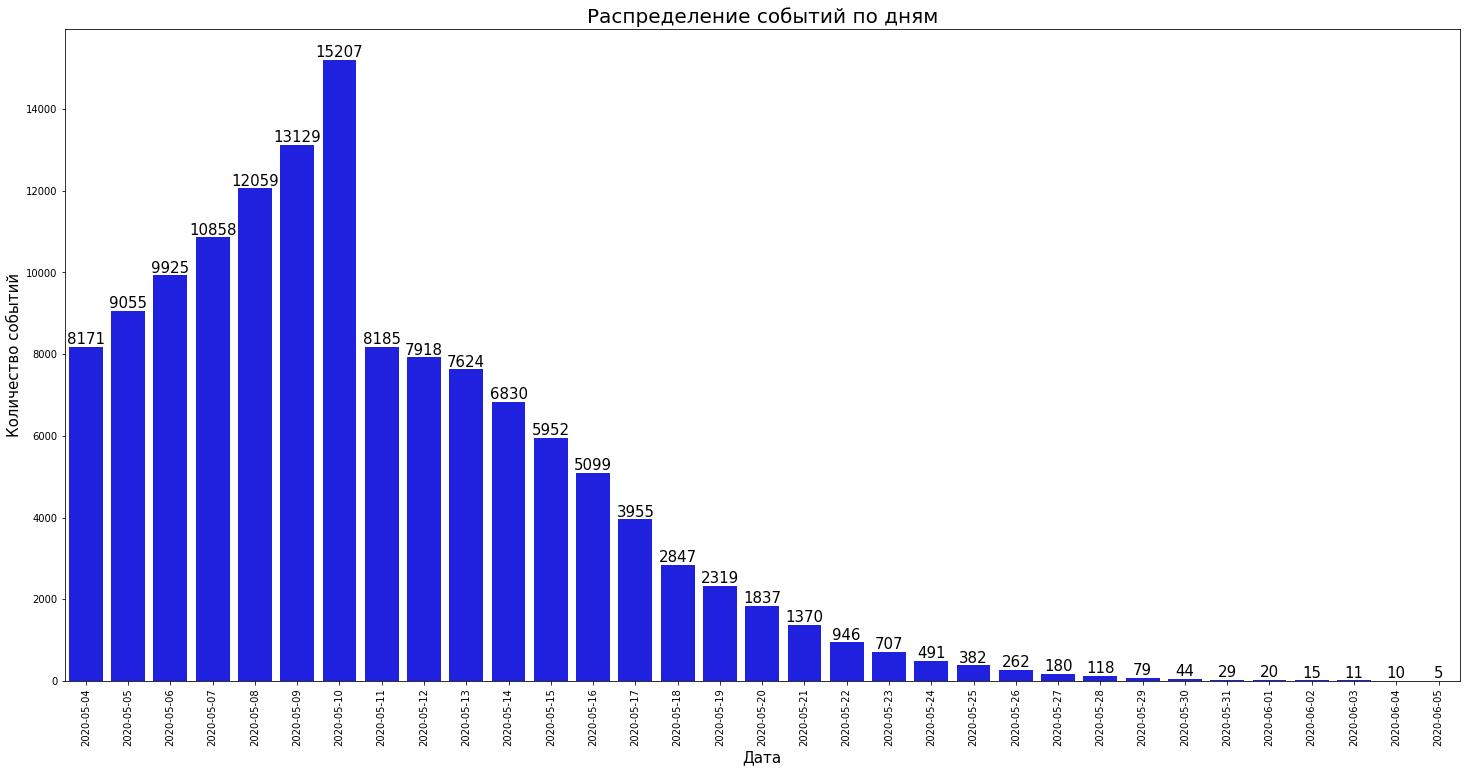

In [13]:
plt.figure(figsize=(25, 12))
plt.title('Распределение событий по дням', fontsize=20)
ax = sns.barplot(x=game_actions.groupby('event_date').agg({'event' : 'count'}).index, 
            y=game_actions.groupby('event_date').agg({'event' : 'count'})['event'], color='blue')
ax.bar_label(ax.containers[0], fontsize=15)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Количество событий', fontsize=15)
plt.xticks(rotation=90)
plt.show()

Количество событий растёт с 4.05 по 10.05 (с 8171 до 15207), 11.05 количество событий резко снижается до 8185 и далее продолжает ежедневно снижаться (5.06 количество событий составило всего 5). Т.е. наибольшую ативность пользователи проявляют в течении нескольких дней (до 1 недели) после привлечения.

### Распределение событий по типу

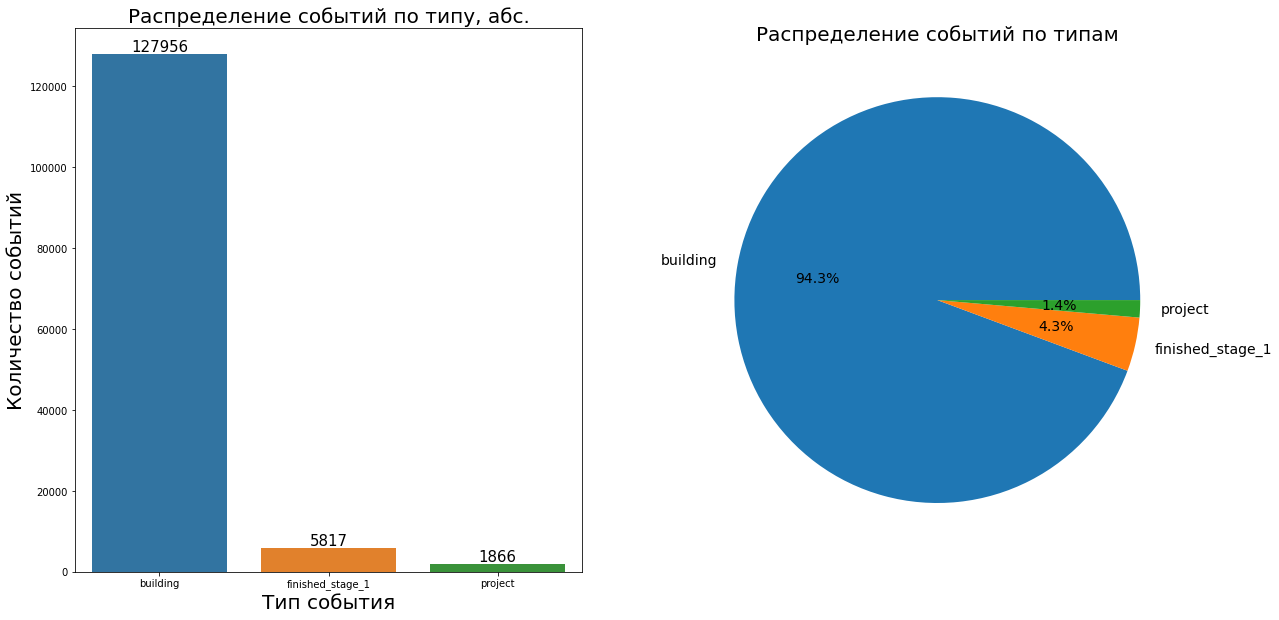

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
a = sns.barplot(ax=ax[0], x=game_actions.groupby('event').agg({'user_id' : 'count'}).index, 
            y=game_actions.groupby('event').agg({'user_id' : 'count'})['user_id'])
a.bar_label(a.containers[0], fontsize=15)
a.set_title('Распределение событий по типу, абс.', fontsize=20)
a.set_xlabel('Тип события', fontsize=20)
a.set_ylabel('Количество событий', fontsize=20)

plt.title('Распределение событий по типам', fontsize=20)
plt.pie(x=game_actions.groupby('event').agg({'user_id' : 'count'})['user_id'], 
        labels=game_actions.groupby('event').agg({'user_id' : 'count'}).index, 
        autopct='%.1f%%', textprops={'fontsize': 14})
plt.show()

Самое частое событие - это постройка здания ('building'), оно произошло 127956 раз и его доля в структуре событий составляет 94,3%. Вторым по частоте является событие 'final_stage_1', означающее что игрок завершил первый уровень через победу над врагом, таким образом первый уровень был завершён 5817 раз и его доля составляет 4,3%. Реже всего происходило событие 'project', т.е. завершение уровня через реализацию проекта, данное событие регестрировалось 1866 раз и составляет 1,4% от всех событий.   

### Распределение построек по типу

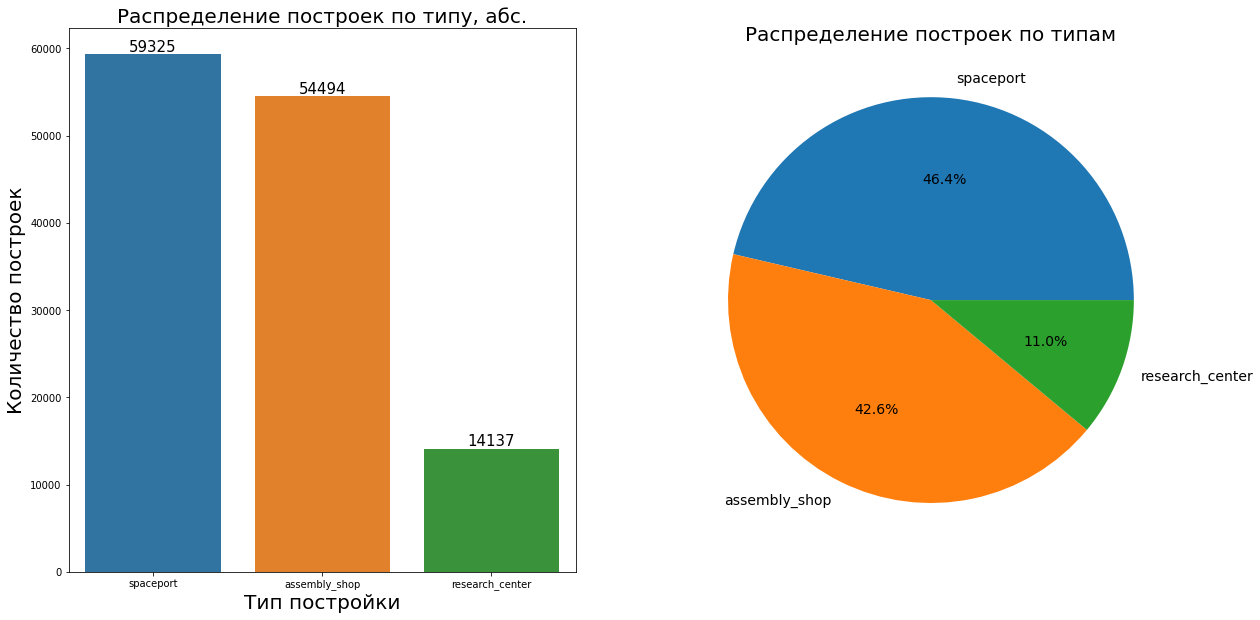

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
a = sns.barplot(ax=ax[0], x=game_actions.groupby('building_type').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False).index, 
            y=game_actions.groupby('building_type').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False)['user_id'])
a.bar_label(a.containers[0], fontsize=15)
a.set_title('Распределение построек по типу, абс.', fontsize=20)
a.set_xlabel('Тип постройки', fontsize=20)
a.set_ylabel('Количество построек', fontsize=20)

plt.title('Распределение построек по типам', fontsize=20)
plt.pie(x=game_actions.groupby('building_type').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False)['user_id'], 
        labels=game_actions.groupby('building_type').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False).index, 
        autopct='%.1f%%', textprops={'fontsize': 14})
plt.show()

Чаще всего игроки строят 'spaceport', всего построено 59325 зданий такого типа, их доля составляет 46,4% от всех построек. Немногим реже строятся 'assembly_shop' - 54494 или 42,6%. Самая редкая постройка - 'research_center' - её построили всего 14137 раз или 11,0%. Такое распределение может быть связано с тем, что 'research_center' необходимо построить однократно, а остальные постройки можно возводить по несколько раз. Кроме того, постройка 'research_center' может быть связана с завершением уровня через реализацию проекта, а т.к. таким образом заканчивают уровень наименьшее количество игроков, то логично, что и постройка данного типа должна быть наименее распространенной.

### Распределение игроков по каналам привлечения

Для удобства отображения переименуем значения в столбце 'source' датафрейма *user_source*.

In [16]:
user_source = user_source.replace({'source' : {'yandex_direct' : 'Yandex', 'instagram_new_adverts' : 'Instagram', 
                                               'facebook_ads' : 'Facebook', 'youtube_channel_reklama' : 'Youtube'}})

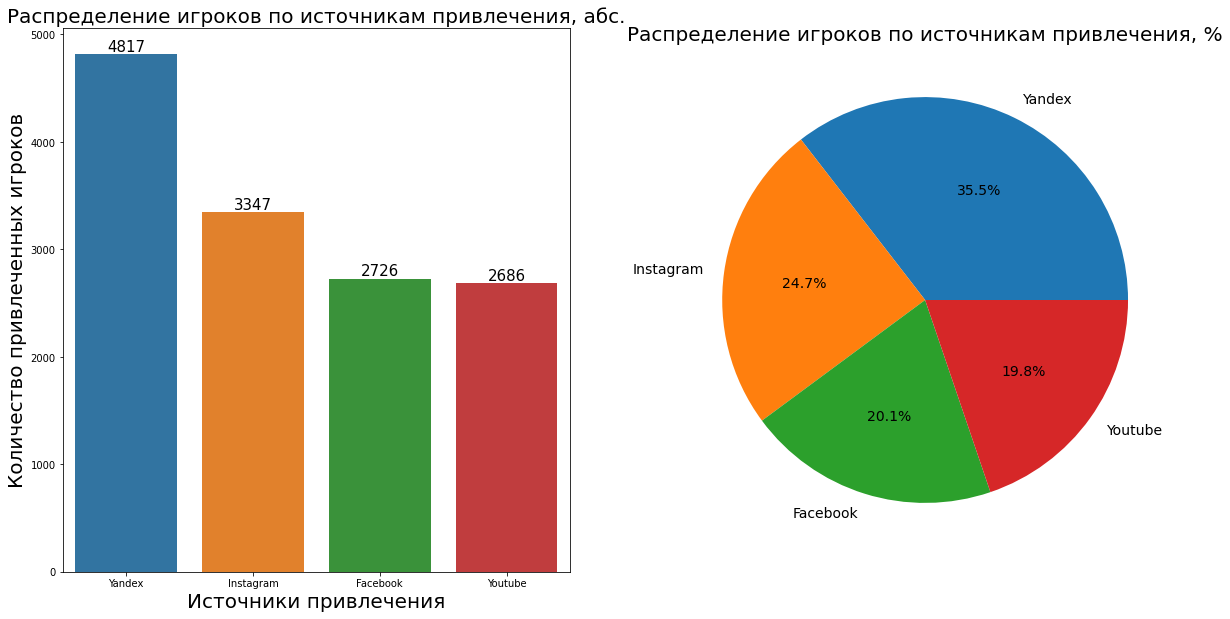

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
a = sns.barplot(ax=ax[0], x=user_source.groupby('source').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False).index, 
            y=user_source.groupby('source').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False)['user_id'])
a.bar_label(a.containers[0], fontsize=15)
a.set_title('Распределение игроков по источникам привлечения, абс.', fontsize=20)
a.set_xlabel('Источники привлечения', fontsize=20)
a.set_ylabel('Количество привлеченных игроков', fontsize=20)

plt.title('Распределение игроков по источникам привлечения, %', fontsize=20)
plt.pie(x=user_source.groupby('source').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False)['user_id'], 
        labels=user_source.groupby('source').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False).index, 
        autopct='%.1f%%', textprops={'fontsize': 14})
plt.show()

Большая часть игроков пришли через Yandex - их количество 4817, что составляет 35,5% от всех игроков, привлеченных через разные источники. Через Instagram пришло 3347 игроков или 24,7%. Практически одинаковое количество игроков были привлечены через Facebook и Youtube - 2726 и 2686 или 20,1% и 19,8% соответственно.

### Количество событий, совершаемых каждым игроком

#### независимо от канала привлечения

In [18]:
#получение характерных значений показателя "количество событий на игрока" 
game_actions.groupby('user_id').agg({'event' : 'count'})['event'].describe()

count   13,576.00
mean         9.99
std          4.15
min          1.00
25%          6.00
50%         10.00
75%         13.00
max         22.00
Name: event, dtype: float64

Количество событий, совершаемых одним игроком колеблется в пределах от 1 до 22. Среднее значение составляет 9,99 и практически равно медиане, составляющей 10. Стандартное отклонение - 4,15.

Далее построим гистограмму отображающую распределение данного показателя.

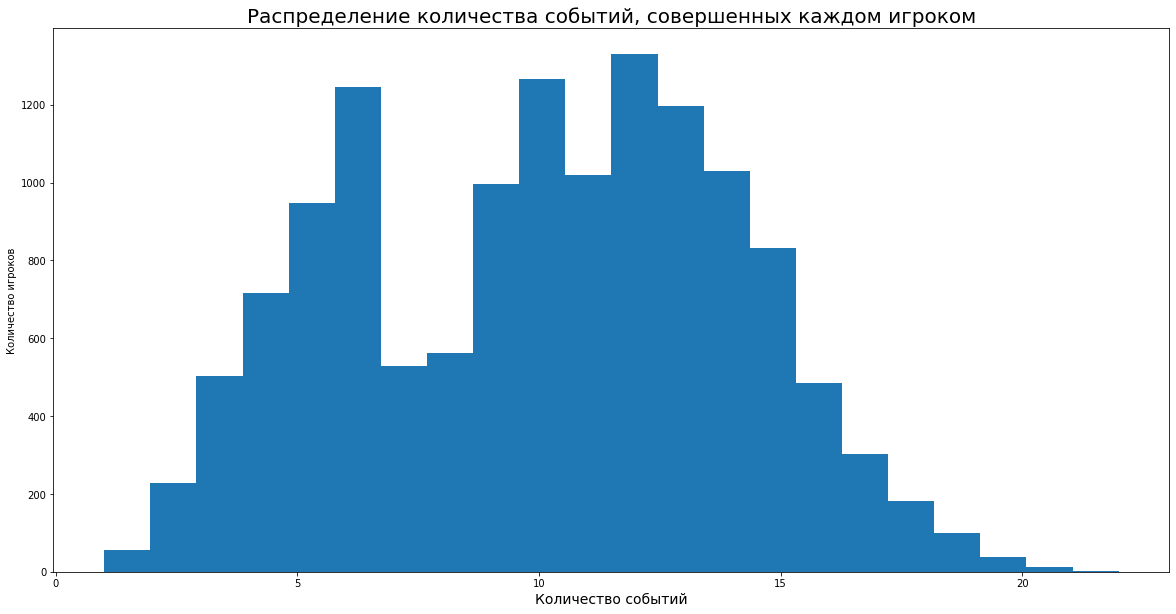

In [19]:
plt.figure(figsize=(20,10))
plt.title('Распределение количества событий, совершенных каждом игроком', fontsize=20)
plt.hist(game_actions.groupby('user_id').agg({'event' : 'count'}), bins=22)
plt.xlabel('Количество событий', fontsize=14)
plt.ylabel('Количество игроков')
plt.show()

На гистограмме видно два пика: большое количество игроков совершает 5-6 событий и 10-15 событий.

#### в разрезе каналов привлечения

В начале добавим информацию об источниках привлечения игроков в датафрейм с событиями.

In [20]:
game_actions = game_actions.merge(user_source, on='user_id', how='left')

Далее изучим характерные значения показателя "количество событий генерируемых каждым игроком" в разрезе каналов привлечения.

In [21]:
#получение характерных значений показателя "количество событий на игрока" для игроков привлечённых через Yandex
game_actions.query('source == "Yandex"').groupby('user_id').agg({'event' : 'count'})['event'].describe()

count   4,817.00
mean        9.90
std         4.13
min         1.00
25%         6.00
50%        10.00
75%        13.00
max        21.00
Name: event, dtype: float64

Характерные значения изучаемого показателя для игроков привлеченных через Yandex, практически аналогичны показателям по всем игрокам. Минимальное и максимальное число генерируемых событий - 1 и 21 соответственно. Среднее значение и медиана составляют 9,90 и 10 соответственно, стандартное отклонение - 4,13. 

In [22]:
#получение характерных значений показателя "количество событий на игрока" по каналу привлечения Instagram
game_actions.query('source == "Instagram"').groupby('user_id').agg({'event' : 'count'})['event'].describe()

count   3,347.00
mean       10.09
std         4.12
min         1.00
25%         6.00
50%        10.00
75%        13.00
max        22.00
Name: event, dtype: float64

Для игроков привлеченных через Instagram, изучаемые показатели идентичны таковым по всем игрокам и по игрокам привлеченным через Yandex. Минимальное и максимальное число генерируемых событий - 1 и 22 соответственно. Среднее значение и медиана составляют 10,09 и 10 соответственно, стандартное отклонение - 4,12.

In [23]:
#получение характерных значений показателя "количество событий на игрока" для игроков привлечённых через Facebook
game_actions.query('source == "Facebook"').groupby('user_id').agg({'event' : 'count'})['event'].describe()

count   2,726.00
mean       10.15
std         4.14
min         1.00
25%         6.00
50%        10.00
75%        13.00
max        22.00
Name: event, dtype: float64

Игроки привлечённые через Facebook также существенно не отличаются, по количеству генерируемых событий, от игроков привлеченных через Yandex и Instagram. Минимальное и максимальное число генерируемых событий - 1 и 22 соответственно. Среднее значение и медиана составляют 10,15 и 10 соответственно, стандартное отклонение - 4,14.

In [24]:
#получение характерных значений показателя "количество событий на игрока" для игроков привлечённых через Youtube
game_actions.query('source == "Youtube"').groupby('user_id').agg({'event' : 'count'})['event'].describe()

count   2,686.00
mean        9.87
std         4.19
min         1.00
25%         6.00
50%        10.00
75%        13.00
max        22.00
Name: event, dtype: float64

Также отсутствуют существенные различия с другими каналами привлечения. Минимальное и максимальное число генерируемых событий - 1 и 22 соответственно. Среднее значение и медиана составляют 9,87 и 10 соответственно, стандартное отклонение - 4,19.

Как видно, разительных отличий по количеству генерируемых событий между игроками, привлёченными через разные каналы, нет. Самое высокое среднее количество генерируемых событий, наблюдается среди игроков, привлечённых через Facebook (10,15), а самое низкое среди игроков привлеченных через Youtube (9,87).

Рассмотрим распределение данного показателя в разрезе каналов привлечения.

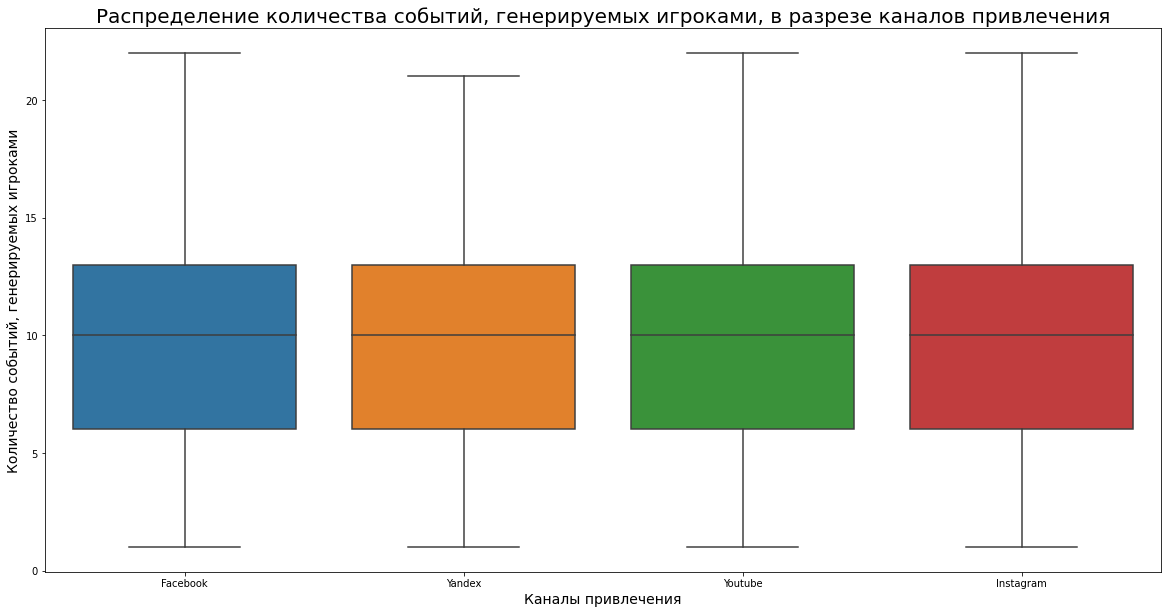

In [25]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(x='source', y='event', data=game_actions.groupby(['user_id', 'source']).agg({'event' : 'count'}
                                                                                       ).reset_index())
ax.set_title('Распределение количества событий, генерируемых игроками, в разрезе каналов привлечения', fontsize=20)
ax.set_ylabel('Количество событий, генерируемых игроками', fontsize=14)
ax.set_xlabel('Каналы привлечения', fontsize=14)
plt.show()

В распределении значений рассматриваемого показателя, отсутствуют какие-либо значимые различия между каналами привлечения игроков.

### Доля игроков завершивших первый уровень¶

#### независимо от канала привлечения

Игроки могут проходить 1-ый уровень двумя способами: через победу над соперником ('finished_stage_1') или через реализацию проекта ('project', а затем 'finished_stage_1'). Но возможно кто-то из игроков завершил проект, но не прошёл 1-ый уровень. Выясним есть ли такие игроки в нашей выборке.

In [26]:
#получение user_id игроков завершивших 1-ый уровень разными способами
filter_level_finished = game_actions.query('event == "finished_stage_1"')['user_id']

#получение user_id игроков завершивших 1-ый уровень, через реализацию исследовательского проекта
filter_project_finished = game_actions.query('event == "project"')['user_id']

game_actions.query('user_id in @filter_project_finished and user_id not in @filter_level_finished')['user_id'].count()

0

Игроков завершивших проект, но не прошедших уровень, в нашей выборке нет.

Далее проведём категоризацию игроков по признаку прохождения 1-ого уровня: 'not_finished' - не прошёл, 'warrior' - через победу над противником, 'scientist' - через реализацию проекта. 

In [27]:
#таблица с перечнем уникальных значений 'event' для каждого пользователя
users_finish = game_actions.groupby(['user_id', 'source']).agg({'event' : 'unique'}).reset_index()

In [28]:
def fin_stage_category(row): #функция для категоризации
    if 'finished_stage_1' not in row['event']:
        return 'not_finished'
    elif 'finished_stage_1' in row['event'] and 'project' not in row['event']:
        return 'warrior'
    elif 'project' in row['event']:
        return 'scientist'
    else:
        return ''

In [29]:
users_finish['strategy'] = users_finish.apply(fin_stage_category, axis=1)

In [30]:
print('Количество игроков, завершивших первый уровень:', len(users_finish.query('strategy != "not_finished"'))
     )
print('Доля игроков, завершивших первый уровень: {:.0%}'.format(len(users_finish.query('strategy != "not_finished"'))
                                                                / len(users_finish)))

Количество игроков, завершивших первый уровень: 5817
Доля игроков, завершивших первый уровень: 43%


In [31]:
print('Количество игроков, завершивших первый уровень через победу над врагом:', 
      len(users_finish.query('strategy == "warrior"'))
     )
print('Количество игроков, завершивших первый уровень через реализацию проекта:', 
      len(users_finish.query('strategy == "scientist"'))
     )
print('Доля игроков, завершивших первый уровень через победу над врагом: {:.0%}'.format(
    len(users_finish.query('strategy == "warrior"')) / len(users_finish))
     )
print('Доля игроков, завершивших первый уровень через победу над врагом: {:.0%}'.format(
    len(users_finish.query('strategy == "warrior"')) / len(users_finish)))

Количество игроков, завершивших первый уровень через победу над врагом: 3951
Количество игроков, завершивших первый уровень через реализацию проекта: 1866
Доля игроков, завершивших первый уровень через победу над врагом: 29%
Доля игроков, завершивших первый уровень через победу над врагом: 29%


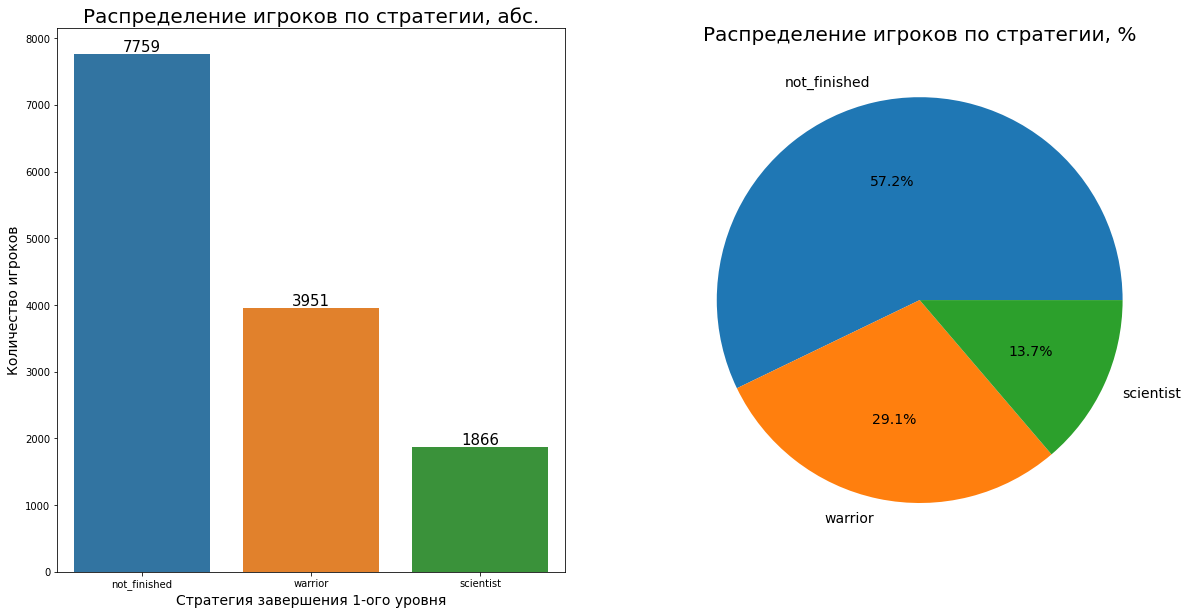

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
a = sns.barplot(ax=ax[0], x=users_finish.groupby('strategy').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False).index, 
            y=users_finish.groupby('strategy').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False)['user_id'])
a.bar_label(a.containers[0], fontsize=15)
a.set_title('Распределение игроков по стратегии, абс.', fontsize=20)
a.set_xlabel('Стратегия завершения 1-ого уровня', fontsize=14)
a.set_ylabel('Количество игроков', fontsize=14)

plt.title('Распределение игроков по стратегии, %', fontsize=20)
plt.pie(x=users_finish.groupby('strategy').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False)['user_id'], 
        labels=users_finish.groupby('strategy').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False).index, 
        autopct='%.1f%%', textprops={'fontsize': 14})
plt.show()

В изучаемой выборке, первый уровень был завершён 5817 игроками, что составило 43% от общего количества игроков. Через победу над первым игроком первый уровень завершил 3951 игрок, а через реализацию проекта 1866 игроков, что составило 29% и 14% от общего количества игроков в выборке. 

#### в разрезе каналов привлечения

In [33]:
for val in game_actions['source'].unique():
    print(f'Количество игроков, привлеченных через {val} и завершивших первый уровень:', 
          len(users_finish[users_finish['source'] == val].query('strategy != "not_finished"'))
         )
    print('Доля игроков, завершивших первый уровень, среди привлеченных через {}: {:.0%}'.format(val, 
        len(users_finish[users_finish['source'] == val].query('strategy != "not_finished"')) / 
        len(users_finish[users_finish['source'] == val]))
         )
    print(f'Количество игроков, привлеченных через {val} и завершивших первый уровень через победу над противником:', 
          len(users_finish[users_finish['source'] == val].query('strategy == "warrior"'))
         )
    print('Доля игроков, завершивших первый уровень через победу над врагом, среди привлеченных через {}: {:.0%}'.format(
        val, len(users_finish[users_finish['source'] == val].query('strategy == "warrior"')) / 
        len(users_finish[users_finish['source'] == val]))
         )
    print('Количество игроков, завершивших первый уровень через реализацию проекта:', 
          len(users_finish[users_finish['source'] == val].query('strategy == "scientist"'))
         )
    print('Доля игроков, завершивших первый уровень через реализацию проекта, среди привлеченных через {}: {:.0%}'.format(
        val, len(users_finish[users_finish['source'] == val].query('strategy == "scientist"')) / 
        len(users_finish[users_finish['source'] == val]))
         )
    print()

Количество игроков, привлеченных через Youtube и завершивших первый уровень: 1159
Доля игроков, завершивших первый уровень, среди привлеченных через Youtube: 43%
Количество игроков, привлеченных через Youtube и завершивших первый уровень через победу над противником: 780
Доля игроков, завершивших первый уровень через победу над врагом, среди привлеченных через Youtube: 29%
Количество игроков, завершивших первый уровень через реализацию проекта: 379
Доля игроков, завершивших первый уровень через реализацию проекта, среди привлеченных через Youtube: 14%

Количество игроков, привлеченных через Facebook и завершивших первый уровень: 1150
Доля игроков, завершивших первый уровень, среди привлеченных через Facebook: 42%
Количество игроков, привлеченных через Facebook и завершивших первый уровень через победу над противником: 759
Доля игроков, завершивших первый уровень через победу над врагом, среди привлеченных через Facebook: 28%
Количество игроков, завершивших первый уровень через реализац

В разрезе каналов привлечения, нет ярких различий по изученным параметрам. Самая высокая доля игроков, завершивших первый уровень - 44% - наблюдается среди игроков, привлеченных через Instagram. Аналогичный показатель среди игроков, привлеченных через Youtube составляет 43%. Среди игроков, привлеченных через Yandex и Facebook, доля завершивших 1-ый уровень, составляет по 42%. 

Наиболее высокие доли игроков, завершивших первый уровень через победу над врагом, наблюдаются среди привлеченных через Instagram и Yandex - по 30%. Среди игроков привлеченных через Youtube и Facebook, данный показатель составляет 29% и 28% соответственно.

Доли игроков привлеченных через Youtube, Instagram, Facebook и завершивших первый уровень через реализацию проекта составили по 14%. Среди игроков, привлеченных через Yandex, аналогичный показатель составляет 13%.

### Расчёт стоимости привлечения игрока (CAC) через разные каналы

Для расчёта CAC необходимо общие затраты на рекламу через определённый канал поделить на количество привлечённых игроков. Начнём с замены названий каналов привлечения в датафрейме *ad_costs*, как ранее это сделали в датафрейме *user_source*.

In [34]:
ad_costs = ad_costs.replace({'source' : {'yandex_direct' : 'Yandex', 'instagram_new_adverts' : 'Instagram', 
                                               'facebook_ads' : 'Facebook', 'youtube_channel_reklama' : 'Youtube'}})

In [35]:
#рассчёт САС по каждому каналу привлечения
for val in game_actions['source'].unique():
    print('САС игроков через {}: {:.2f}'.format(val, (ad_costs[ad_costs['source'] == val]['cost'].sum() / 
                                                      game_actions[game_actions['source'] == val]['user_id'].nunique())))

САС игроков через Youtube: 0.40
САС игроков через Facebook: 0.79
САС игроков через Instagram: 0.65
САС игроков через Yandex: 0.46


Дороже всего обходится привлечения игроков через Facebook - 0,79 у.е. Далее следуют игроки привлечённые через Instagram - 0,65 у.е. Стоимость привлечения игрока через Yandex оценивается в 0,46 у.е., и аналогичный показатель для игроков при влеченных через Youtube - 0,40 у.е.

### Промежуточный вывод

1. Поведение игроков независимо от канала привлечения:
    - количество генерируемых игроками событий растёт в первую неделю анализируемого периода, а начиная с 8-ого дня количество событий постоянно падает, т.е. наибольшая активность пользователей приходится на первые несколько дней после привлечения;
    - 94,3% генерируемых событий составляет постройка зданий, на завершение первого уровня приходится 4,3% и на реализацию проекта - 1,4%;
    - в основном игроки строят 'spaceport' и 'assembly_shop' на которые приходится 46,4% и 42,6% возводимых построек соответственно, оставшиеся 11,0% приходятся на 'research_center';
    - в среднем каждый игрок генерирует около десяти событий, чаще всего игроки генерируют 5-6 или 10-15 событий;
    - доля игроков завершивших первый уровень состаила 43%; 29% игроков завершили первый уровень через победу над противником и 14% через реализацию проекта.
2. Поведение игроков в разрезе каналов привлечения:
- наибольшая доля игроков пришла через Yandex - 35,5%; 24,7% и 20,1% игроков пришли через Instagram и Facebook соответственно;  меньше всего игроков было привлечено через рекламу на Youtube - 19,8%;
- среднее количество событий генерируемых игроками в зависимости от канала привлечения сущесственно не различается и варьируется от 9,87 для игроков, привлечённых через Youtube, до 10,15 для игроков, привлечённых через Facebook, распределение данного показателя для каждого из каналов привлечения сходно с таковым для общей совокупности;
- доли игроков завершивших первый уровень, в т.ч. разными способами, практически идентичны аналогичным показателям для общей совокупности, а именно доля завершивших первый уровень 42-44%; через победу над противником - 28-30%; через реализацию исследовательского проекта - 13-14%.
3. Самая высокая стоимость привлечения зафиксирована у игроков пришедших через Facebook -  0,79 у.е.; стоимость привлечения игроков через Instagram - 0,65 у.е.; через Yandex - 0,46 у.е.; наименьшей стоимостью привлечения обладают игроки пришедшие через Youtube - 0,40 у.е.

## Проверка статистической гипотезы "Время завершения уровня различается в зависимости от способа прохождения"

Начнем с изучения распределения время, потраченного на завершение первого уровня игроками.

In [36]:
game_actions = game_actions.merge(users_finish[['user_id', 'strategy']], on='user_id', how='left') 
#добавление к основному фрейму данных о стратегии игроков

Среднее количество дней, затраченных на завершение 1-ого уровня: 12


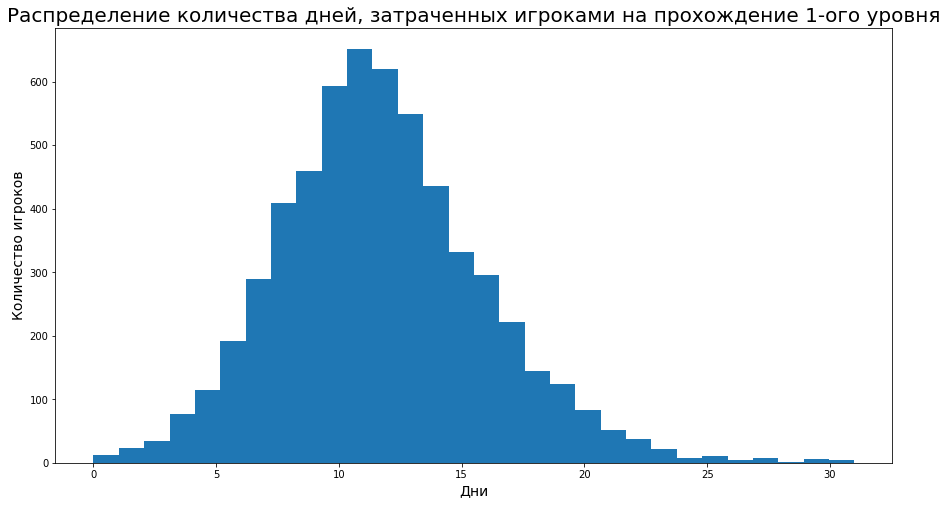

In [37]:
#рассчет среднего количества дней, затраченных на заврешение 1-ого уровня
print('Среднее количество дней, затраченных на завершение 1-ого уровня:', (game_actions.query(
    'strategy != "not_finished"').groupby('user_id').agg({'event_datetime' : 'max'})['event_datetime'] - 
    game_actions.query('strategy != "not_finished"').groupby('user_id').agg(
        {'event_datetime' : 'min'})['event_datetime']).mean().round('1d').days)

#гистограмма распределения дней, затраченных на завершение первого уровня
plt.figure(figsize=(15, 8))
plt.hist((game_actions.query('strategy != "not_finished"').groupby('user_id').agg(
    {'event_datetime' : 'max'})['event_datetime'] - game_actions.query('strategy != "not_finished"').groupby(
    'user_id').agg({'event_datetime' : 'min'})['event_datetime']).round('1d').apply(lambda x: x.days), bins=30)
plt.title('Распределение количества дней, затраченных игроками на прохождение 1-ого уровня', fontsize=20)
plt.ylabel('Количество игроков', fontsize=14)
plt.xlabel('Дни', fontsize=14)
plt.show()

В среднем на прохождение 1-ого уровня игроками затрачивается 12 дней, распределение значений показателя близко к нормальному, поэтому для проверки статистической гипотезы считаю уместным использовать t-критерий Стьюдента для непарных выборок. Но сначала сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза: "Время завершения уровня не различается в зависимости от способа прохождения".
- Альтернативная гипотеза: "Время завершения уровня различается в зависимости от способа прохождения".

In [38]:
#дни, затраченные игроками на завершение 1-ого уровня через победу над противником
days_warrior = (game_actions.query('strategy == "warrior"').groupby('user_id').agg(
    {'event_datetime' : 'max'})['event_datetime'] - game_actions.query('strategy == "warrior"').groupby('user_id').agg(
          {'event_datetime' : 'min'})['event_datetime']).round('1d').apply(lambda x: x.days)

#дни, затраченные игроками на завершение 1-ого уровня через реализацию проекта
days_scientist = (game_actions.query('strategy == "scientist"').groupby('user_id').agg(
    {'event_datetime' : 'max'})['event_datetime'] - game_actions.query('strategy == "scientist"').groupby('user_id').agg(
          {'event_datetime' : 'min'})['event_datetime']).round('1d').apply(lambda x: x.days)
alpha = 0.05 #критический уровень статистической значимости

results = st.ttest_ind(days_warrior, days_scientist, equal_var=False)

print('Среднее количество дней, затраченных на завершение 1-ого уровня через победу над противником: {:.0f}'.format(
    days_warrior.mean())
     )
print('Среднее количество дней, затраченных на завершение 1-ого уровня через реализацию проекта: {:.0f}'.format(
    days_scientist.mean())
     )
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Нулевая гипотеза отвергнута')
else:
    print('Нельзя отвергнуть нулевую гипотезу')

Среднее количество дней, затраченных на завершение 1-ого уровня через победу над противником: 11
Среднее количество дней, затраченных на завершение 1-ого уровня через реализацию проекта: 13
p-значение:  1.0867598832876934e-106
Нулевая гипотеза отвергнута


Время затраченное на завершение 1-ого уровня статистически достоверно различается в зависимости от способа прохождения. Так игроки завершающие уровень через победу над врагом тратят на это в среднем 11 дней, а игроки реализующие исследовательский проект - 13 дней.

### Промежуточный вывод

Мы выяснили, что игрокам, реализующим исследовательский проект, требуется в среднем на 2 дня больше на прохождение 1-ого уровня, чем игрокам, заканчивающим его через победу над врагом (13 против 11 дней). С одной стороны игроки, занимающиеся проектом проводят в игре больше времени, что может рассматриваться, как позитивный момент, но мы не знаем каким будет их поведение на следующих уровнях, возможно отток среди игроков практикующих более "миролюбивый" стиль игры будет увеличиваться со временем, а может и нет. 

## Проверка статистической гипотезы "Доля игроков завершивших первый уровень различается в зависимости от канала привлечения"

Ранее мы уже рассчитали доли игроков завершивших первый уровень для каждого из каналов привлечения. На первый взгляд они практически не различаются, но чтобы убедиться в этом используем z-тест для сравнения долей в каждой группе. Игроков привлечённых через Yandex и Facebook сравнивать не будем, так как доля завершивших 1-ый уровень и там, и там составляет по 42%. Необходимо учесть, что мы будем проводить множественные сравнения, а значит нужно сделать поправку критического уровня статистической значимости, для чего используем поправку Бонферрони.

Нулевая гипотеза: "Доли игроков заврешивших первый уровень не различаются в разных каналах привлечения".
Альтернативная гипотеза: "Доли игроков заврешивших первый уровень различаются в разных каналах привлечения".

In [39]:
def z_test(x1, n1, x2, n2):
    
    bonferroni_alpha = .05/6 #критический уровень статистической значимости c поправкой Бонферрони

    event = np.array([x1, x2]) #количество совершивших событие пользователей
    group = np.array([n1, n2]) #количество пользователей в группах
        
    p1 = event[0]/group[0] #доля пользователей, совершивших событие в первой группе
    p2 = event[1]/group[1]  #доля пользователей, совершивших событие во второй группе

    p_combined = (event[0] + event[1]) / (group[0] + group[1]) #доля пользователей, совершивших события в объединённой группе

    difference = p1 - p2 #разница долей в группах
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / event[0] + 1 / event[1])) #расчет z-статистики

    distr = st.norm(0, 1) #задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    
    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

###  Yandex vs Instagram

In [40]:
print('Доля игроков, завершивших первый уровень, среди привлеченных через Yandex: {:.0%}'.format(game_actions[game_actions[
        'source'] == 'Yandex'].query('event == "finished_stage_1"')['user_id'].nunique() / game_actions[
    game_actions['source'] == 'Yandex']['user_id'].nunique()))
print('Доля игроков, завершивших первый уровень, среди привлеченных через Instagram: {:.0%}'.format(game_actions[game_actions[
        'source'] == 'Instagram'].query('event == "finished_stage_1"')['user_id'].nunique() / game_actions[
    game_actions['source'] == 'Instagram']['user_id'].nunique()))

Доля игроков, завершивших первый уровень, среди привлеченных через Yandex: 42%
Доля игроков, завершивших первый уровень, среди привлеченных через Instagram: 44%


In [41]:
z_test(game_actions[game_actions['source'] == 'Yandex'].query('event == "finished_stage_1"')['user_id'].nunique(), 
       game_actions[game_actions['source'] == 'Yandex']['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Instagram'].query('event == "finished_stage_1"')['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Instagram']['user_id'].nunique())

p-значение:  0.4057495175003498
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


###  Yandex vs Youtube

In [42]:
print('Доля игроков, завершивших первый уровень, среди привлеченных через Yandex: {:.0%}'.format(game_actions[game_actions[
        'source'] == 'Yandex'].query('event == "finished_stage_1"')['user_id'].nunique() / game_actions[
    game_actions['source'] == 'Yandex']['user_id'].nunique()))
print('Доля игроков, завершивших первый уровень, среди привлеченных через Youtube: {:.0%}'.format(game_actions[game_actions[
        'source'] == 'Youtube'].query('event == "finished_stage_1"')['user_id'].nunique() / game_actions[
    game_actions['source'] == 'Youtube']['user_id'].nunique()))

Доля игроков, завершивших первый уровень, среди привлеченных через Yandex: 42%
Доля игроков, завершивших первый уровень, среди привлеченных через Youtube: 43%


In [43]:
z_test(game_actions[game_actions['source'] == 'Yandex'].query('event == "finished_stage_1"')['user_id'].nunique(), 
       game_actions[game_actions['source'] == 'Yandex']['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Youtube'].query('event == "finished_stage_1"')['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Youtube']['user_id'].nunique())

p-значение:  0.6768229801770342
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


###  Yandex vs Facebook

In [44]:
print('Доля игроков, завершивших первый уровень, среди привлеченных через Yandex: {:.0%}'.format(game_actions[game_actions[
        'source'] == 'Yandex'].query('event == "finished_stage_1"')['user_id'].nunique() / game_actions[
    game_actions['source'] == 'Yandex']['user_id'].nunique()))
print('Доля игроков, завершивших первый уровень, среди привлеченных через Facebook: {:.0%}'.format(game_actions[game_actions[
        'source'] == 'Facebook'].query('event == "finished_stage_1"')['user_id'].nunique() / game_actions[
    game_actions['source'] == 'Facebook']['user_id'].nunique()))

Доля игроков, завершивших первый уровень, среди привлеченных через Yandex: 42%
Доля игроков, завершивших первый уровень, среди привлеченных через Facebook: 42%


In [45]:
z_test(game_actions[game_actions['source'] == 'Yandex'].query('event == "finished_stage_1"')['user_id'].nunique(), 
       game_actions[game_actions['source'] == 'Yandex']['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Facebook'].query('event == "finished_stage_1"')['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Facebook']['user_id'].nunique())

p-значение:  0.9103163488352839
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


###  Instagram vs Youtube

In [46]:
print('Доля игроков, завершивших первый уровень, среди привлеченных через Instagram: {:.0%}'.format(game_actions[game_actions[
        'source'] == 'Instagram'].query('event == "finished_stage_1"')['user_id'].nunique() / game_actions[
    game_actions['source'] == 'Instagram']['user_id'].nunique()))
print('Доля игроков, завершивших первый уровень, среди привлеченных через Youtube: {:.0%}'.format(game_actions[game_actions[
        'source'] == 'Youtube'].query('event == "finished_stage_1"')['user_id'].nunique() / game_actions[
    game_actions['source'] == 'Youtube']['user_id'].nunique()))

Доля игроков, завершивших первый уровень, среди привлеченных через Instagram: 44%
Доля игроков, завершивших первый уровень, среди привлеченных через Youtube: 43%


In [47]:
z_test(game_actions[game_actions['source'] == 'Instagram'].query('event == "finished_stage_1"')['user_id'].nunique(), 
       game_actions[game_actions['source'] == 'Instagram']['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Youtube'].query('event == "finished_stage_1"')['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Youtube']['user_id'].nunique())

p-значение:  0.7384185096583284
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


###  Instagram vs Facebook

In [48]:
print('Доля игроков, завершивших первый уровень, среди привлеченных через Instagram: {:.0%}'.format(game_actions[game_actions[
        'source'] == 'Instagram'].query('event == "finished_stage_1"')['user_id'].nunique() / game_actions[
    game_actions['source'] == 'Instagram']['user_id'].nunique()))
print('Доля игроков, завершивших первый уровень, среди привлеченных через Facebook: {:.0%}'.format(game_actions[game_actions[
        'source'] == 'Facebook'].query('event == "finished_stage_1"')['user_id'].nunique() / game_actions[
    game_actions['source'] == 'Facebook']['user_id'].nunique()))

Доля игроков, завершивших первый уровень, среди привлеченных через Instagram: 44%
Доля игроков, завершивших первый уровень, среди привлеченных через Facebook: 42%


In [49]:
z_test(game_actions[game_actions['source'] == 'Instagram'].query('event == "finished_stage_1"')['user_id'].nunique(), 
       game_actions[game_actions['source'] == 'Instagram']['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Facebook'].query('event == "finished_stage_1"')['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Facebook']['user_id'].nunique())

p-значение:  0.40797025861071834
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


###  Youtube vs Facebook

In [50]:
print('Доля игроков, завершивших первый уровень, среди привлеченных через Youtube: {:.0%}'.format(game_actions[game_actions[
        'source'] == 'Youtube'].query('event == "finished_stage_1"')['user_id'].nunique() / game_actions[
    game_actions['source'] == 'Youtube']['user_id'].nunique()))
print('Доля игроков, завершивших первый уровень, среди привлеченных через Facebook: {:.0%}'.format(game_actions[game_actions[
        'source'] == 'Facebook'].query('event == "finished_stage_1"')['user_id'].nunique() / game_actions[
    game_actions['source'] == 'Facebook']['user_id'].nunique()))

Доля игроков, завершивших первый уровень, среди привлеченных через Youtube: 43%
Доля игроков, завершивших первый уровень, среди привлеченных через Facebook: 42%


In [51]:
z_test(game_actions[game_actions['source'] == 'Youtube'].query('event == "finished_stage_1"')['user_id'].nunique(), 
       game_actions[game_actions['source'] == 'Youtube']['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Facebook'].query('event == "finished_stage_1"')['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Facebook']['user_id'].nunique())

p-значение:  0.6398197240187653
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Промежуточный вывод

В результате проверки выдвинутой гипотезы мы выяснили что между долями игроков из разных каналов привлечения, завершивших первый уровень, отсутствует статистически достоверная разница.

## Проверка статистической гипотезы "Среднее количество построек на игрока различается в зависимости от факта завершения уровня и способа его завершения"

В начале изучим распределение количества строений возводимых каждым игроком.

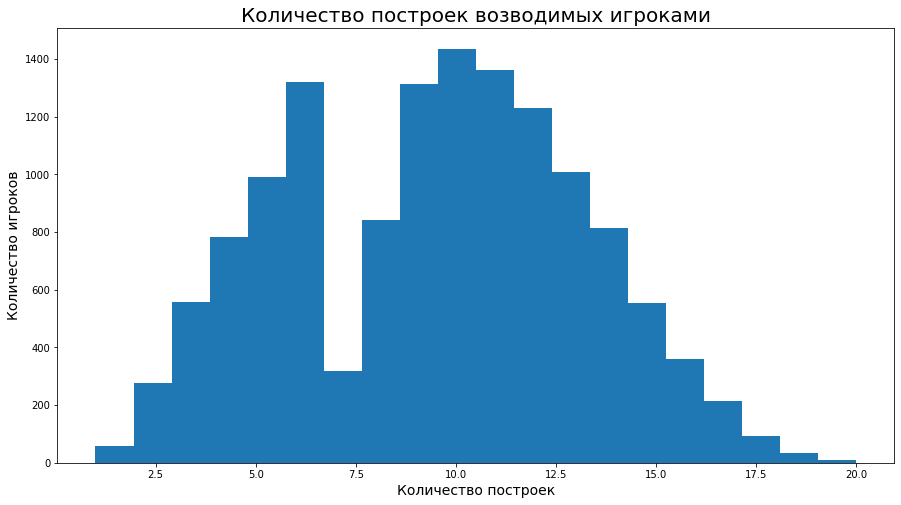

In [52]:
plt.figure(figsize=(15,8))
plt.hist(game_actions.query('event == "building"').groupby('user_id').agg({'event' : 'count'}), bins=20)
plt.title('Количество построек возводимых игроками', fontsize=20)
plt.ylabel('Количество игроков', fontsize=14)
plt.xlabel('Количество построек', fontsize=14)
plt.show()

Есть провал в районе 7 построек на игрока, но в целом распределение близко к нормальному, поэтому считаю уместным использование для тестирования гипотезы t-критерия Стьюдента для независимых выборок. В нашем случае мы будем сравнивать между собой три группы (игроки, незавершившие 1-ый уровень; игроки, завершившившие 1-ый уровень через победу над врагом; игроки завершившие 1-ый уровень через реализацию проекта), поэтому нужно сделать поправку критического уровня статистической значимости на множественные сравнения.

Так как тест необходимо провести три раза подряд, напишем для удобства соответствующую функцию.

In [53]:
def t_test(x, y, bonferroni):#функция для t-теста
    alpha = .05/bonferroni #критический уровень статистической значимости с поправкой Бонферрони
    results = st.ttest_ind(x.to_list(), y.to_list(), equal_var=False)
    print('p-значение: ', results.pvalue)
    if results.pvalue < alpha:
        print('Нулевая гипотеза отвергнута')
    else:
        print('Нельзя отвергнуть нулевую гипотезу')

### Незавершившие 1-ый уровень vs Завершившие 1-ый уровень через победу над врагом

In [54]:
#количество построек, возводимых игроками, незавершившими 1-ый уровень
not_finished_buildings = game_actions.query('strategy == "not_finished"').groupby('user_id').agg({'event' : 'count'}
                                                                                                )['event']

#количество построек, возводимых игроками, завершившими 1-ый уровень через победу над противником
warrior_buildings = game_actions.query('strategy == "warrior" and event == "building"').groupby('user_id').agg(
    {'event' : 'count'})['event']

#количество построек, возводимых игроками, завершившими 1-ый уровень через реализацию проекта
scientist_buildings = game_actions.query('strategy == "scientist" and event == "building"').groupby('user_id').agg(
    {'event' : 'count'})['event']

print('Среднее количество построек, возводимых игроками, незавершившими 1-ый уровень: {:.1f}'.format(
    not_finished_buildings.mean()) 
      )
print('Среднее количество построек, возводимых игроками, завершившими 1-ый уровень через победу над противником: {:.1f}'
      .format(warrior_buildings.mean())
     )
t_test(not_finished_buildings, warrior_buildings, 3)

Среднее количество построек, возводимых игроками, незавершившими 1-ый уровень: 8.7
Среднее количество построек, возводимых игроками, завершившими 1-ый уровень через победу над противником: 9.4
p-значение:  9.746399746547599e-29
Нулевая гипотеза отвергнута


Игроки, завершившие 1-ый уровень через победу над противником, возводят достоверно больше построек, чем игроки, незавершившие 1-ый уровень (9,4 против 8,7).

### Незавершившие 1-ый уровень vs Завершившие 1-ый уровень через реализацию проекта

In [55]:
print('Среднее количество построек, возводимых игроками, незавершившими 1-ый уровень: {:.1f}'.format(
    not_finished_buildings.mean()) 
      )
print('Среднее количество построек, возводимых игроками, завершившими 1-ый уровень через реализацию проекта: {:.1f}'.format(
    scientist_buildings.mean())
     )
t_test(not_finished_buildings, scientist_buildings, 3)

Среднее количество построек, возводимых игроками, незавершившими 1-ый уровень: 8.7
Среднее количество построек, возводимых игроками, завершившими 1-ый уровень через реализацию проекта: 12.6
p-значение:  0.0
Нулевая гипотеза отвергнута


Игроки, завершившие 1-ый уровень через реализацию проекта, также возводят достоверно больше построек, чем игроки, незавершившие 1-ый уровень (12,6 против 8,7).

### Завершившие 1-ый уровень через победу над врагом vs Завершившие 1-ый уровень через реализацию проекта

In [56]:
print('Среднее количество построек, возводимых игроками, завершившими 1-ый уровень через победу над противником: {:.1f}'.format(
    warrior_buildings.mean())
      )
print('Среднее количество построек, возводимых игроками, завершившими 1-ый уровень через реализацию проекта: {:.1f}'.format(
    scientist_buildings.mean())
     )
t_test(warrior_buildings, scientist_buildings, 3)

Среднее количество построек, возводимых игроками, завершившими 1-ый уровень через победу над противником: 9.4
Среднее количество построек, возводимых игроками, завершившими 1-ый уровень через реализацию проекта: 12.6
p-значение:  0.0
Нулевая гипотеза отвергнута


Игроки, завершившие 1-ый уровень через реализацию проекта, возводят достоверно больше построек, чем игроки, завершившие 1-ый уровень через победу над противником (12,6 против 9,4).

### Промежуточный вывод

Игроки, завершающие 1-ый уровень через реализацию проекта, в среднем возводят достоверно больше построек, чем игроки, завершающие 1-ый уровень через победу над противником, и чем игроки, незавершающие 1-ый уровень (среднее значение - 12,6; 9,4 и 8,7 построек на игрока соответственно). Это может быть важно при реализации монетизации, т.к. она планируется через показ рекламы на экране выбора постройки. 

## Общие выводы

1. Поведение игроков независимо от канала привлечения:
- количество генерируемых игроками событий растёт в первую неделю анализируемого периода, а начиная с 8-ого дня количество событий постоянно падает, т.е. наибольшая активность пользователей приходится на первые несколько дней после привлечения;
- 94,3% генерируемых событий составляет постройка зданий, на завершение первого уровня приходится 4,3% и на реализацию проекта - 1,4%;
- в основном игроки строят 'spaceport' и 'assembly_shop' на которые приходится 46,4% и 42,6% возводимых построек соответственно, оставшиеся 11,0% приходятся на 'research_center';
- в среднем каждый игрок генерирует около десяти событий, чаще всего игроки генерируют 5-6 или 10-15 событий;
- доля игроков завершивших первый уровень состаила 43%; 29% игроков завершили первый уровень через победу над противником и 14% через реализацию проекта.
2. Поведение игроков в разрезе каналов привлечения:
- наибольшая доля игроков пришла через Yandex - 35,5%; 24,7% и 20,1% игроков пришли через Instagram и Facebook соответственно;  меньше всего игроков было привлечено через рекламу на Youtube - 19,8%;
- среднее количество событий генерируемых игроками в зависимости от канала привлечения сущесственно не различается и варьируется от 9,87 для игроков, привлечённых через Youtube, до 10,15 для игроков, привлечённых через Facebook, распределение данного показателя для каждого из каналов привлечения сходно с таковым для общей совокупности;
- доли игроков завершивших первый уровень, в т.ч. разными способами, практически идентичны аналогичным показателям для общей совокупности, а именно доля завершивших первый уровень 42-44%; через победу над противником - 28-30%; через реализацию исследовательского проекта - 13-14%.
3. Самая высокая стоимость привлечения зафиксирована у игроков пришедших через Facebook -  0,79 у.е.; стоимость привлечения игроков через Instagram - 0,65 у.е.; через Yandex - 0,46 у.е.; наименьшей стоимостью привлечения обладают игроки пришедшие через Youtube - 0,40 у.е.


4. Результаты проверок статистических гипотез:
- игроки, завершающие 1-ый уровень, через реализацию проекта тратят на прохождение уровня достоверно больше дней, чем игроки, завершающие 1-ый уровень через победу над противником (13 дней против 11 дней);
- доля игроков, завершающих 1-ый уровень, статистически не различается в разрезе каналов привлечения;
- игроки, завершающие 1-ый уровень через реализацию проекта возводят статистически достоверно больше построек, чем игроки, завершающие 1-ый уровень через победу над противником, и чем игроки, незавершающие 1-ый уровень (среднее значение - 12,6; 9,4 и 8,7 построек на игрока соответственно).

**Рекомендации**

1. Нами не было выявлено существенных различий в поведении игроков, привлеченных через разные каналы, поэтому при выборе наиболее оптимальных рекламных каналов стоит, в первую очередь, ориентироваться на стоимость привлечения игрока. По данному параметру предпочтение стоит отдать рекламе через Youtube и Yandex.
2. Мы установили, что игроки, завершающие 1-ый уровень через реализацию проекта, возводят больше построек, чем игроки, нзавершающие 1-ый уровень или завершающие его через победу над противником. Учитывая, что модель планируемой монетизации предполагает показ рекламы на экране выбора постройки, стоит предусмотреть меры побуждения игроков к прохождению уровней через реализацию проекта (внутриигровые награды и трофеи и др.), т.к. тогда они будут чаще попадать на экран показа рекламы.

## Презентация

[https://disk.yandex.ru/i/m1pHSO2vWLjenA]

## Дашборд

[https://public.tableau.com/shared/BQ24783CG?:display_count=n&:origin=viz_share_link]